In [7]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import pandas as pd

In [9]:
df = pd.read_csv('../data/weather.csv')

# Convert time column to datetime
df['time'] = pd.to_datetime(df['time'])

# Sort data by time (important for time series)
df = df.sort_values('time')

# Quick overview
print(df.shape)
print(df.columns)
df.head()

(147480, 24)
Index(['time', 'weathercode', 'temperature_2m_max', 'temperature_2m_min',
       'temperature_2m_mean', 'apparent_temperature_max',
       'apparent_temperature_min', 'apparent_temperature_mean', 'sunrise',
       'sunset', 'shortwave_radiation_sum', 'precipitation_sum', 'rain_sum',
       'snowfall_sum', 'precipitation_hours', 'windspeed_10m_max',
       'windgusts_10m_max', 'winddirection_10m_dominant',
       'et0_fao_evapotranspiration', 'latitude', 'longitude', 'elevation',
       'country', 'city'],
      dtype='object')


,time,weathercode,temperature_2m_max,temperature_2m_min,temperature_2m_mean,apparent_temperature_max,apparent_temperature_min,apparent_temperature_mean,sunrise,sunset,...,precipitation_hours,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,et0_fao_evapotranspiration,latitude,longitude,elevation,country,city
0,2010-01-01,2,30.0,22.7,26.1,34.4,25.2,29.2,6:22:00 AM,6:05:00 PM,...,0,11.7,27.4,20,4.58,7.000000,79.899994,16,Sri Lanka,Colombo
108152,2010-01-01,3,26.7,20.4,23.5,28.4,22.8,25.6,6:20:00 AM,6:01:00 PM,...,0,17.7,42.8,57,3.54,7.599998,80.600006,376,Sri Lanka,Matale
122900,2010-01-01,2,28.5,21.7,24.8,30.4,24.3,27.1,6:21:00 AM,6:02:00 PM,...,0,19.2,43.6,44,4.12,7.500000,80.399994,124,Sri Lanka,Kurunegala
103236,2010-01-01,2,29.7,23.0,26.3,34.3,25.7,30.2,6:20:00 AM,6:06:00 PM,...,0,11.7,27.4,20,4.35,6.500000,80.000000,10,Sri Lanka,Bentota
4916,2010-01-01,2,30.1,22.6,26.1,34.4,24.9,29.1,6:22:00 AM,6:05:00 PM,...,0,11.7,27.4,20,4.61,6.900002,79.899994,10,Sri Lanka,Mount Lavinia


In [10]:
# Extract date features
df['day'] = df['time'].dt.day
df['month'] = df['time'].dt.month
df['year'] = df['time'].dt.year
df['dayofweek'] = df['time'].dt.dayofweek

# Drop columns that are not useful or non-numeric
df = df.drop(columns=['time', 'sunrise', 'sunset', 'country', 'city'])

# Drop rows with NaNs if any
df = df.dropna()

In [11]:
target = 'temperature_2m_max'
X = df.drop(columns=[target])
y = df[target]


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

In [17]:
params = {
    'objective': 'reg:squarederror',  # regression objective
    'eval_metric': 'rmse',            # root mean squared error
    'max_depth': 4,
    'eta': 0.1,
    'seed': 42
}

In [18]:
print(y.unique())

[30.  26.7 28.5 29.7 30.1 24.4 29.4 29.9 29.5 27.8 27.5 30.6 27.3 27.6
 29.2 29.8 25.3 29.6 30.2 24.2 27.  29.3 24.3 25.6 26.8 28.9 27.9 28.4
 28.6 27.7 29.1 25.  27.2 25.7 28.3 26.3 23.6 23.4 26.5 28.7 27.4 28.2
 28.8 27.1 29.  22.8 28.  23.9 28.1 26.6 26.4 24.9 24.8 23.  24.1 25.4
 24.6 22.5 25.9 25.1 26.  26.9 23.8 26.2 30.3 26.1 30.5 25.5 30.7 30.8
 30.4 23.7 31.2 31.1 31.  30.9 25.8 23.2 31.3 31.4 24.5 31.5 22.7 24.
 25.2 32.3 32.9 31.6 32.5 32.6 32.4 24.7 32.7 31.8 32.8 31.9 32.2 32.
 33.2 31.7 33.1 33.  21.7 22.4 23.5 32.1 22.3 33.3 33.7 33.6 34.2 34.6
 33.4 33.5 33.8 34.  33.9 35.1 35.3 34.5 34.3 34.7 36.2 34.9 36.5 34.1
 35.2 35.4 36.1 36.  35.  35.5 35.9 36.7 36.6 35.7 34.8 35.6 36.3 37.
 36.4 34.4 36.9 37.2 22.6 22.1 22.2 22.9 21.4 21.3 21.9 23.3 21.6 23.1
 22.  21.8 21.1 20.9 20.8 21.5 20.5 20.1 19.2 19.5 21.  21.2 19.  20.
 19.1 19.8 19.4 17.5 20.2 20.4 20.6 19.6 35.8 37.5 20.7 37.1 36.8 37.3
 20.3]


In [19]:
model = xgb.train(params, dtrain, num_boost_round=100)

In [20]:
from xgboost import XGBRegressor

reg = XGBRegressor(max_depth=4, learning_rate=0.1, n_estimators=100)
reg.fit(X_train, y_train)

# Make predictions
y_pred = reg.predict(X_test)


In [22]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

print("MAE:", mean_absolute_error(y_test, y_pred))

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print("RMSE:", rmse)

print("R² Score:", r2_score(y_test, y_pred))


MAE: 0.2690367369785004
RMSE: 0.34712076717611634
R² Score: 0.9729164481825429


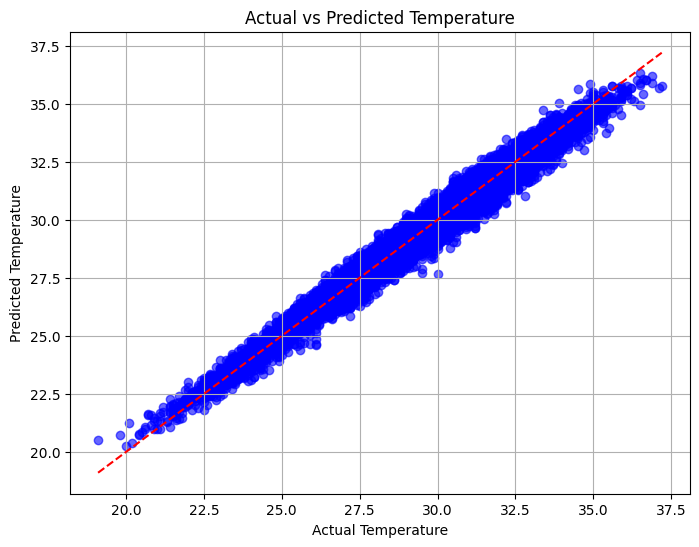

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, alpha=0.6, color='blue')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Temperature')
plt.ylabel('Predicted Temperature')
plt.title('Actual vs Predicted Temperature')
plt.grid(True)
plt.show()


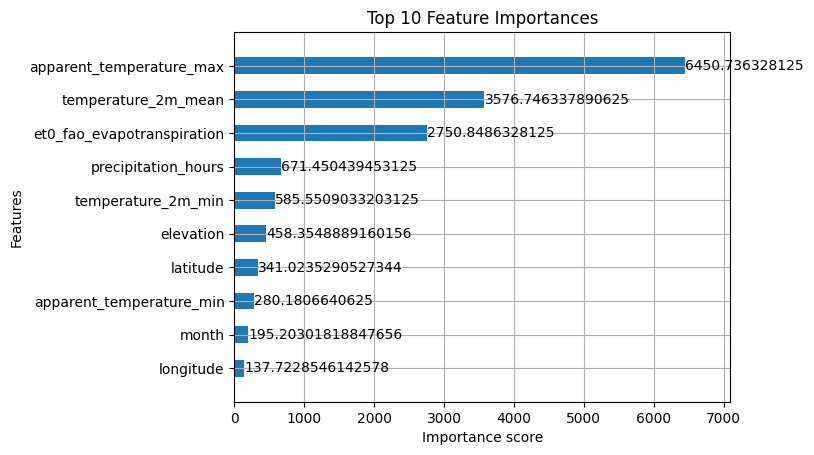

In [28]:
import xgboost as xgb

xgb.plot_importance(reg, importance_type='gain', max_num_features=10, height=0.5)
plt.title('Top 10 Feature Importances')
plt.show()



In [31]:
import joblib

joblib.dump(reg, 'xgboost_weather_model.pkl')
print("Model saved successfully!")


Model saved successfully!
